In [4]:
import math
import os
import re
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats
import yaml
import neutcurve
import scipy.stats
print(f"Using `neutcurve` version {neutcurve.__version__}")
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import linregress

# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

#import altair themes from /data/custom_analyses_data/theme.py and enable
import theme
alt.themes.register('main_theme', theme.main_theme)
alt.themes.enable('main_theme')
from pathlib import Path

repo_root = Path.cwd().parent
os.chdir(repo_root)
print(os.getcwd())
#print(os.listdir("raw_plate_reader"))
plt.rcParams['svg.fonttype'] = 'none' #from bernadeta, for correct font svg output

Using `neutcurve` version 2.1.0
/fh/fast/bloom_j/computational_notebooks/tmcmahon/2024/02_RSV/RSV_evolution_neut


In [5]:
# Load your dataset (adjust the path as needed)
# Example format assumed:
# | p24 (ng/mL) | Replicate | Absorbance |
df = pd.read_csv("01_data/other/2025.05.09_Absorbance_p24ELISA.csv")

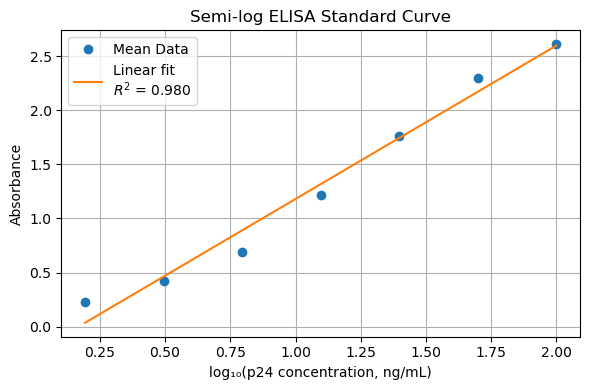

In [6]:
# Average absorbance for each concentration
avg_df = df.groupby('p24 (ng/mL)', as_index=False)['Absorbance'].mean()

# Log-transform the x-values (avoid log10(0))
avg_df = avg_df[avg_df['p24 (ng/mL)'] > 0].copy()
avg_df['log_p24'] = np.log10(avg_df['p24 (ng/mL)'])

# Fit a linear regression on log-transformed concentration
slope, intercept, r_value, p_value, std_err = linregress(avg_df['log_p24'], avg_df['Absorbance'])

# Predict values for plotting regression line
x_fit = np.linspace(avg_df['log_p24'].min(), avg_df['log_p24'].max(), 100)
y_fit = slope * x_fit + intercept

# Plot
plt.figure(figsize=(6, 4))
plt.plot(avg_df['log_p24'], avg_df['Absorbance'], 'o', label='Mean Data')
plt.plot(x_fit, y_fit, '-', label=f'Linear fit\n$R^2$ = {r_value**2:.3f}')
plt.xlabel('log₁₀(p24 concentration, ng/mL)')
plt.ylabel('Absorbance')
plt.title('Semi-log ELISA Standard Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Load unknown absorbance data with replicates
unknowns = pd.read_csv("01_data/other/p24_unknowns.csv")

# Average replicates
avg_unknowns = unknowns.groupby('Sample', as_index=False)['Absorbance'].mean()

# Interpolate p24 concentration from absorbance
avg_unknowns['log_p24'] = (avg_unknowns['Absorbance'] - intercept) / slope
avg_unknowns['p24_concentration_ng_per_mL'] = 10 ** avg_unknowns['log_p24']

# Drop intermediate log column if you want
avg_unknowns = avg_unknowns.drop(columns='log_p24')
avg_unknowns

# Optional: Save to CSV
# avg_unknowns.to_csv("interpolated_concentrations.csv", index=False)

,Sample,Absorbance,p24_concentration_ng_per_mL
0,Conc RSV Long F + G 31AACTdel,1.95330,35.030235
1,Conc RSV Long F + G full CT,1.84440,29.357538
2,RSV Long F + G 31AACTdel,1.71530,23.810289
3,RSV Long F + G full CT,1.81315,27.906350
4,blank,0.03425,1.557445
5,media,0.03610,1.562126


In [10]:
# Load unknown absorbance data with replicates and dilution info
unknowns = pd.read_csv("01_data/other/p24_unknowns.csv")
# STEP 1: Average replicates, compute std dev, and carry forward dilution factor
avg_unknowns = unknowns.groupby('Sample', as_index=False).agg({
    'Absorbance': ['mean', 'std'],
    'Dilution Factor': 'first'
})

# Flatten multi-level column names
avg_unknowns.columns = ['Sample', 'Absorbance_mean', 'Absorbance_std', 'Dilution Factor']

# STEP 2: Interpolate and propagate error
# Convert mean absorbance to log10(p24)
avg_unknowns['log_p24'] = (avg_unknowns['Absorbance_mean'] - intercept) / slope

# Propagate error in absorbance through log transform
avg_unknowns['log_p24_std'] = avg_unknowns['Absorbance_std'] / abs(slope)

# Convert to linear p24 concentration
avg_unknowns['p24_concentration_ng_per_mL'] = 10 ** avg_unknowns['log_p24']

# Propagate error: d(10^x)/dx = ln(10) * 10^x
avg_unknowns['p24_conc_std'] = (
    np.log(10) * avg_unknowns['p24_concentration_ng_per_mL'] * avg_unknowns['log_p24_std']
)

# Apply dilution correction
avg_unknowns['p24_titer_ng_per_mL'] = avg_unknowns['p24_concentration_ng_per_mL'] * avg_unknowns['Dilution Factor'] * 0.25
avg_unknowns['p24_titer_std'] = avg_unknowns['p24_conc_std'] * avg_unknowns['Dilution Factor'] * 0.25

# Convert to LPs/mL
avg_unknowns['LPs_per_mL'] = avg_unknowns['p24_titer_ng_per_mL'] * 1.25e7
avg_unknowns['LPs_std'] = avg_unknowns['p24_titer_std'] * 1.25e7


In [13]:
import altair as alt

# Define log ticks and labels for Plot 2
log_ticks = [10**i for i in range(4, 9)]  # 10⁴ to 10⁸
log_labels = ["10⁴", "10⁵", "10⁶", "10⁷", "10⁸"]
y_label_expr = "{ " + ", ".join(f"{v}: '{label}'" for v, label in zip(log_ticks, log_labels)) + " }[datum.value]"

# Ensure Sample is treated as categorical
avg_unknowns['Sample'] = avg_unknowns['Sample'].astype(str)

# Common x-axis definition with improved label visibility
x_axis = alt.X(
    'Sample:N',
    title='',
    axis=alt.Axis(
        labelAngle=270,
        labelLimit=300,
        labelFontSize=14,
        labelFontWeight='bold',
        titleFontSize=16,
        titleFontWeight='bold'
    )
)

# Plot 1: p24 Titer (linear)
plot1 = alt.Chart(avg_unknowns).mark_point(
    size=100, filled=True, opacity=1, stroke='black', strokeWidth=1.2, color='lightgray'
).encode(
    x=x_axis,
    y=alt.Y(
        'p24_titer_ng_per_mL:Q',
        title='p24 Titer (ng/mL)',
        axis=alt.Axis(
            labelFontSize=14,
            labelFontWeight='bold',
            titleFontSize=16,
            titleFontWeight='bold',
            grid=False
        )
    ),
    tooltip=[
        alt.Tooltip('Sample:N'),
        alt.Tooltip('p24_titer_ng_per_mL:Q', title='p24 Titer (ng/mL)', format=".2f")
    ]
).properties(
    title='p24 Titer per Sample',
    width=400,
    height=300
)

# Define log ticks and labels for Plot 2
log_ticks = [10**i for i in range(6, 10)]  # 10⁶ to 10⁹
log_labels = ["10⁶", "10⁷", "10⁸", "10⁹"]
y_label_expr = "{ " + ", ".join(f"{v}: '{label}'" for v, label in zip(log_ticks, log_labels)) + " }[datum.value]"

# Plot 2 with error bars (log scale)
error_bars = alt.Chart(avg_unknowns[avg_unknowns['LPs_per_mL'] > 0]).mark_errorbar().encode(
    x='Sample:N',
    y='LPs_per_mL:Q',
    yError='LPs_std:Q'
)

# Create new columns for ymin/ymax
avg_unknowns['LPs_per_mL_minus'] = avg_unknowns['LPs_per_mL'] - avg_unknowns['LPs_std']
avg_unknowns['LPs_per_mL_plus'] = avg_unknowns['LPs_per_mL'] + avg_unknowns['LPs_std']

# Define base for plotting
base = avg_unknowns[avg_unknowns['LPs_per_mL'] > 0]


# Points (behind)
points = alt.Chart(base).mark_point(
    size=100, filled=True, opacity=1, stroke='black', strokeWidth=1.2, color='lightgray'
).encode(
    x=x_axis,
    y=alt.Y(
        'LPs_per_mL:Q',
        title='Lentiviral particles per mL',
        scale=alt.Scale(type='log', domain=[1e6, 1e9]),
        axis=alt.Axis(
            values=log_ticks,
            labelExpr=y_label_expr,
            grid=False,
            labelFontSize=16,
            labelFontWeight='bold',
            titleFontSize=16,
            titleFontWeight='bold'
        )
    ),
    tooltip=[
        alt.Tooltip('Sample:N'),
        alt.Tooltip('LPs_per_mL:Q', title='Lentiviral particles per mL', format=".2e"),
        alt.Tooltip('LPs_std:Q', title='Error', format=".2e")
    ]
)

# Vertical lines (error bars)
rules = alt.Chart(base).mark_rule(color='black').encode(
    x='Sample:N',
    y=alt.Y('LPs_per_mL_minus:Q'),
    y2='LPs_per_mL_plus:Q'
)

# Caps (short horizontal ticks)
caps = alt.Chart(base).mark_tick(
    color='black',
    thickness=2,
    size=10  # this controls cap width
).encode(
    x='Sample:N',
    y='LPs_per_mL_minus:Q'
) + alt.Chart(base).mark_tick(
    color='black',
    thickness=2,
    size=10
).encode(
    x='Sample:N',
    y='LPs_per_mL_plus:Q'
)

# Create new columns for ymin/ymax
avg_unknowns['LPs_per_mL_minus'] = avg_unknowns['LPs_per_mL'] - avg_unknowns['LPs_std']
avg_unknowns['LPs_per_mL_plus'] = avg_unknowns['LPs_per_mL'] + avg_unknowns['LPs_std']

# Combine all layers
plot2 = (points + rules + caps).properties(
    title='Lentiviral Particles per Sample',
    width=200,
    height=200
)

# Combine and configure
combined = (plot1 & plot2).configure_axis(
    labelFontSize=14,
    labelFontWeight='bold',
    titleFontSize=16,
    titleFontWeight='bold'
).configure_view(
    strokeWidth=0
)

combined.save("03_output/plots/p24_Titer.html")
combined

alt.VConcatChart(...)